In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [3]:
#resize all images to this size (Resizing image into bigger size of 224, 224 for clarity)
IMAGE_SIZE = [224,224]
#height  = 224, width = 224, Channels = 3

train_path = 'Dataset/Train'
test_path = 'Dataset/Test'

In [4]:
vgg19 = VGG19(input_shape = IMAGE_SIZE  + [3], weights = 'imagenet', include_top = False)

In [5]:
#To avoid training the exising weights in the layers
for layer in vgg19.layers:
    layer.trainable = False

In [6]:
#This is useful in getting the number of output classes
folders = glob('Dataset/Train/*')

In [7]:
#In the first layer we will give our own image size and in the last layer we will give the number of classes that must be there

In [8]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
folders

[]

In [10]:
x = Flatten()(vgg19.output)

In [11]:
prediction = Dense(len(folders), activation = 'softmax')(x)  #Adding our output layer

#Create a model object
model = Model(inputs = vgg19.input, outputs = prediction)

In [12]:
#View the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
from tensorflow.keras.layers import MaxPooling2D

In [14]:
#Creating model from scratch using CNN
#We are freexing all the layers except the last layer, last layer needs to be trained again and again 
#until we get better result


model = Sequential()
model.add(Conv2D(filters = 16,kernel_size = 2, padding='same',activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32,kernel_size = 2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64,kernel_size = 2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Flatten())
model.add(Dense(500, activation = 'relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0

In [15]:
#tell the model what cost and optimization method to use
model.compile(
    loss = 'categorical_crossentropy',  #since we have two nodes we have use categorical else we would have used binary
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [16]:
#Use the image dtagenerator to import images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
                                )
#We augmented training set bcoz we will use that to train our model, and we font need to modify our test as we just need to predict that

test_datagen = ImageDataGenerator(rescale = 1./255)

Using TensorFlow backend.


In [17]:
#Make sure that you provide the same target size as initialised for the image

training_set = train_datagen.flow_from_directory('Dataset Malaria/Train',
                                                target_size = (224,224),
                                                batch_size = 6,
                                                class_mode = 'categorical')

Found 416 images belonging to 2 classes.


In [18]:
 training_set

In [19]:
test_set = test_datagen.flow_from_directory('Dataset Malaria/Test',
                                           target_size = (224,224),
                                           batch_size = 6,
                                           class_mode='categorical')

Found 134 images belonging to 2 classes.


In [20]:
#Fitting our model
r = model.fit(
    training_set,
    validation_data = test_set,
    epochs = 10,
    steps_per_epoch = len(training_set),
    validation_steps = len(test_set)
)

Train for 70 steps, validate for 23 steps
Epoch 1/10
70/70 [==============================] - 62s 880ms/step - loss: 0.9515 - accuracy: 0.5865 - val_loss: 1.0634 - val_accuracy: 0.2985
Epoch 2/10
70/70 [==============================] - 70s 997ms/step - loss: 0.5238 - accuracy: 0.7404 - val_loss: 0.6861 - val_accuracy: 0.5373
Epoch 3/10
70/70 [==============================] - 68s 975ms/step - loss: 0.4332 - accuracy: 0.8197 - val_loss: 0.6476 - val_accuracy: 0.5672
Epoch 4/10
70/70 [==============================] - 74s 1s/step - loss: 0.4792 - accuracy: 0.8221 - val_loss: 0.9455 - val_accuracy: 0.4179
Epoch 5/10
70/70 [==============================] - 71s 1s/step - loss: 0.3111 - accuracy: 0.8726 - val_loss: 0.7581 - val_accuracy: 0.6418
Epoch 6/10
70/70 [==============================] - 72s 1s/step - loss: 0.2213 - accuracy: 0.9327 - val_loss: 0.3831 - val_accuracy: 0.8284
Epoch 7/10
70/70 [==============================] - 79s 1s/step - loss: 0.1593 - accuracy: 0.9495 - val_loss:

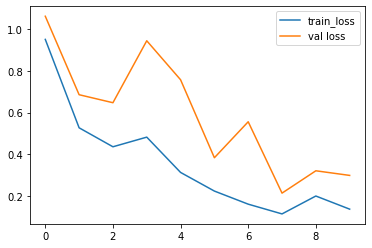

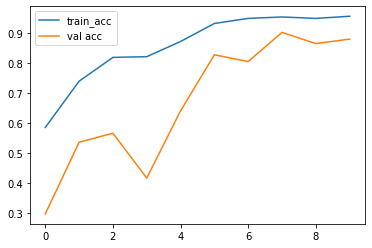

<Figure size 432x288 with 0 Axes>

In [21]:
# Plot the loss
plt.plot(r.history['loss'], label = 'train_loss')
plt.plot(r.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

#Plot the accuracy
plt.plot(r.history['accuracy'], label='train_acc')
plt.plot(r.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

#Saving the model as a h5 file

from tensorflow.keras.models import load_model
model.save('malaria_vgg19.h5')

y_pred = model.predict(test_set)

y_pred  #Sum of each pair in a line would be 1
#If 1st value is higher than parasited image, if second value is higher then it is an uninfected image

y_pred.shape

import numpy as np
y_pred = np.argmax(y_pred, axis = 1)

y_pred

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('malaria_vgg19.h5')

img = image.load_img(r"Dataset Malaria\Train\Uninfected\4.png", target_size = (224,224))

img

x = image.img_to_array(img)
x

x.shape

x=x/(1./255)  #To rescale the image down

x = np.expand_dims(x, axis = 0)
img_data = preprocess_input(x)
img_data.shape

model.predict(img_data)

a = np.argmax(model.predict(img_data),axis = 1)

a

if(a==1):
    print("Your report suggests that you are not infected with Malaria")
else:
    print("Your report suggests that you are infected with Malaria")

from keras.models import model_from_json

json_model = model.to_json()

with open('malaria_model', 'w') as json_file:
    json_file.write(json_model)

model.save_weights('malaria_weights.h5')

pip install -Uq tf-nightly-gpu